In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf
import multiprocessing as mp
from keras import optimizers,regularizers 
from sklearn import metrics 
from keras.optimizers import Adam,SGD

Using TensorFlow backend.


# **Loading the dataset**

first we will download cifar10 dataset directly from keras. 

In [2]:
from keras.datasets import cifar10

In [3]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

**Examining the dataset**

first we check the shape of our dataset.

In [4]:
trainX.shape

(50000, 32, 32, 3)

In [5]:
trainY.shape

(50000, 1)

In [6]:
testX.shape

(10000, 32, 32, 3)

**We will use 20 % of train data as training data**

We have 50000 training and 10000 test data. this is image data set with a structure of (32,32,3) which correspond to (width, height, RGB).
For each image there is a corresponding label, which is a class index. 
We will use 20 % train data out of 50000 that is 10000. 


In [7]:
number_of_rows = int(trainX.shape[0] * 0.2)
x_train = trainX[:number_of_rows]
x_train.shape

(10000, 32, 32, 3)

In [8]:
y_train = trainY[:number_of_rows]
y_train.shape

(10000, 1)

#### Test validation split 50-50 %

In [9]:
x_test, x_val, y_test, y_val = train_test_split(testX, testY, test_size = 0.5, shuffle= True)
print(x_test.shape, x_val.shape, y_test.shape, y_val.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3) (5000, 1) (5000, 1)


#### Normalization

Using to_categorical we convert the target vectors into binary class vectors. Since it is a image dataset so the dimensions will be between 0 to 1. MLP takes on 2 D (3072) dimensional vector as the input.

First we are going to use a Multilayer Perceptron to classify our images dataset.

In [10]:
x_train_norm = x_train.astype('float32')
x_test_norm = x_test.astype('float32')
x_val_norm =x_val.astype('float32')

# Normalise data
x_train_norm /= 255.0
x_test_norm /= 255.0
x_val_norm/=255.0

### MLP Classifier

In [11]:
from keras.utils import to_categorical

In [12]:
x_train_mlp =np.reshape(x_train_norm, (10000, 3072))
y_train_mlp = to_categorical(y_train, num_classes = 10) 

In [13]:
x_val_mlp = np.reshape(x_val_norm, (5000, 3072))
y_val_mlp = to_categorical(y_val, num_classes = 10)

In [14]:
x_test_mlp = np.reshape(x_test_norm, (5000, 3072))
y_test_mlp = to_categorical(y_test, num_classes = 10)

In [15]:
# Build the MLP model.
model = Sequential()
model.add(Dense(512, activation='sigmoid', input_dim = 3072))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model.compile(optimizer=optimizers.Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [17]:
import time
start=time.time()
history = model.fit(x_train_mlp, y_train_mlp, batch_size=32, epochs=5, validation_data=(x_val_mlp,y_val_mlp), shuffle =True)
end=time.time()
model_time=end-start
print("Total training time is {:0.2f} minute".format(model_time/60.0))

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 16s 2ms/step - loss: 2.0433 - accuracy: 0.2415 - val_loss: 1.9022 - val_accuracy: 0.3002
Epoch 2/5
10000/10000 [==============================] - 16s 2ms/step - loss: 1.8847 - accuracy: 0.3112 - val_loss: 1.8716 - val_accuracy: 0.3098
Epoch 3/5
10000/10000 [==============================] - 16s 2ms/step - loss: 1.8195 - accuracy: 0.3398 - val_loss: 1.8548 - val_accuracy: 0.3426
Epoch 4/5
10000/10000 [==============================] - 16s 2ms/step - loss: 1.7681 - accuracy: 0.3635 - val_loss: 1.8028 - val_accuracy: 0.3346
Epoch 5/5
10000/10000 [==============================] - 15s 2ms/step - loss: 1.7284 - accuracy: 0.3700 - val_loss: 1.8216 - val_accuracy: 0.3268
Total training time is 1.32 minute


In [18]:
score = model.evaluate(x_test_mlp, y_test_mlp, batch_size=32, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


Test loss: 1.8050615550994873 / Test accuracy: 0.34360000491142273


**Plot Loss Vs Epochs**

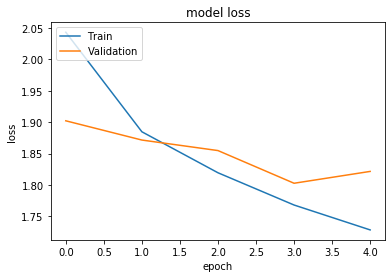

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

Figure shows validation loss is increasing after 2nd epoch whereas training loss is decreasing. 

**Plot Accuracy Vs Epochs**

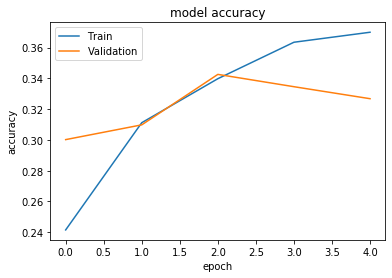

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

Training accuracy is increasing with epochs, however validation accuracy is fluctuating. if we train our model with large number of epochs it gives good results.

### **CNN_part 1**

**Preparing the dataset**

In [21]:
x_test, x_val, y_test, y_val = train_test_split(testX, testY, test_size = 0.5, random_state = 42)
print(x_test.shape, x_val.shape, y_test.shape, y_val.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3) (5000, 1) (5000, 1)


In [22]:
y_train_cnn = to_categorical(y_train, num_classes=10)
y_test_cnn = to_categorical(y_test, num_classes=10)
y_val_cnn = to_categorical(y_val, num_classes=10)
x_train_cnn = x_train.astype('float32')
x_test_cnn = x_test.astype('float32')
x_val_cnn = x_val.astype('float32')
x_train_cnn /= 255
x_test_cnn /= 255

In [23]:
print("Shape of training data:")
print(x_train_cnn.shape)
print(y_train_cnn.shape)
print("Shape of validation data:")
print(x_val_cnn.shape)
print(y_val_cnn.shape)
print("Shape of test data:")
print(x_test_cnn.shape)
print(y_test_cnn.shape)

Shape of training data:
(10000, 32, 32, 3)
(10000, 10)
Shape of validation data:
(5000, 32, 32, 3)
(5000, 10)
Shape of test data:
(5000, 32, 32, 3)
(5000, 10)


**Creating the CNN Model**

We will use two convolutional layers, each with 64 filters a kernel size of (3,3) and ReLU activation function. We will use padding same and 2 fully connected dense layer with 512 units and sigmoid activation function. At last we will use output layer i.e no of classes =10 and softmax activiaction function, since we are solving classification problem.

In [24]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same',input_shape=(32, 32, 3)))
model.add(Conv2D(64,(3, 3),activation='relu', padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512, activation = 'sigmoid'))
model.add(Dense(units = 512, activation = 'sigmoid'))
model.add(Dense(units = 10, activation = 'softmax'))

Model.summary gives the model summary

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               33554944  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 33,861,450
Trainable params: 33,861,450
Non-trainable params: 0
__________________________________________

Model.Compile the model, where  we will use adam optimizer with 0.001 learning rate. Here we define categorical_crossentropy loss function (used for single label categorization) and accuracy as an evaluation matrics.

In [26]:
model.compile(optimizer=optimizers.Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

**Trainning the CNN_1 Model**

In [27]:
import time
start=time.time()
cnn_1 = model.fit(x_train_cnn, y_train_cnn, batch_size=32, epochs=5, validation_data=(x_val_cnn,y_val_cnn), shuffle = True)
end=time.time()
model_time=end-start
print("Total training time is {:0.2f} minute".format(model_time/60.0))

Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 325s 32ms/step - loss: 1.7738 - accuracy: 0.3482 - val_loss: 1.7168 - val_accuracy: 0.4042
Epoch 2/5
10000/10000 [==============================] - 332s 33ms/step - loss: 1.2883 - accuracy: 0.5331 - val_loss: 1.6994 - val_accuracy: 0.4168
Epoch 3/5
10000/10000 [==============================] - 328s 33ms/step - loss: 0.9254 - accuracy: 0.6709 - val_loss: 1.6449 - val_accuracy: 0.4330
Epoch 4/5
10000/10000 [==============================] - 328s 33ms/step - loss: 0.5376 - accuracy: 0.8212 - val_loss: 1.8011 - val_accuracy: 0.4548
Epoch 5/5
10000/10000 [==============================] - 329s 33ms/step - loss: 0.2063 - accuracy: 0.9441 - val_loss: 2.0355 - val_accuracy: 0.4566
Total training time is 27.40 minute


**Plot Loss Vs Epochs**

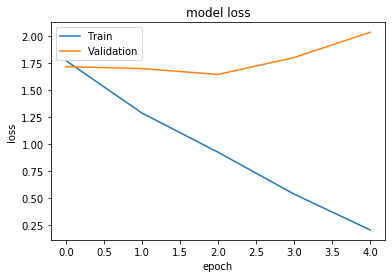

In [28]:
plt.plot(cnn_1.history['loss'])
plt.plot(cnn_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()


figure shows higher validation loss compare to training loss.

**Plot Accuracy Vs Epochs**

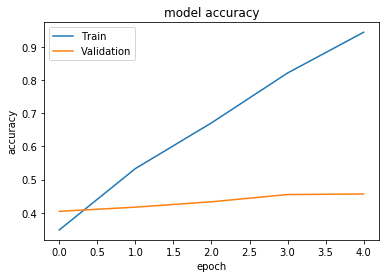

In [29]:
plt.plot(cnn_1.history['accuracy'])
plt.plot(cnn_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()


Training accuracy is almost 90 % here and  validation accuracy is 47 %. This plot shows greater overfitting presents in the modelperformance. 

**Evaluation on Test Data**

In [30]:
score = model.evaluate(x_test_cnn, y_test_cnn, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.6355941301345824 / Test accuracy: 0.5437999963760376


As we can see, the CNN reached significantly higher accuracy than the MLP classifier, but overfitting occured during the training of our model. To avoid this, the use of some regularization techniques would be advised. So we will train our next model using dropout layer and maxpooling2D.
To avoid overfitting we add 'Dropout' layer. Dropout is implemented per-layer in a neural network and randomly dropping out nodes during training. It offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks.Dropout can be implemented on any or all hidden layers in the network as well as the input layer. It is not used on the output layer. We have kept the dropout rate 0.2 in this model. 

# **PART 3 CNN with dropout Layer**

In [31]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size=(3, 3), padding = 'same',activation='relu', input_shape= (32,32,3)))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(64, kernel_size=(3, 3),padding = 'same', activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('sigmoid'))
model_2.add(Dropout(0.2))
model_2.add(Dense(512))
model_2.add(Activation('sigmoid'))
model_2.add(Dropout(0.2))
model_2.add(Dense(10))
model_2.add(Activation('softmax'))
    

In [32]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               2097664   
_________________________________________________________________
activation_1 (Activation)    (None, 512)              

In [33]:
model_2.compile(optimizer=optimizers.Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

In [34]:
import time
start=time.time()
cnn_2 = model_2.fit(x_train_cnn, y_train_cnn, batch_size=32, epochs=5, validation_data=(x_val_cnn,y_val_cnn), shuffle = True)
end=time.time()
model_time=end-start
print("Total training time is {:0.2f} minute".format(model_time/60.0))

Train on 10000 samples, validate on 5000 samples
Epoch 1/5
10000/10000 [==============================] - 56s 6ms/step - loss: 1.9727 - accuracy: 0.2659 - val_loss: 1.6749 - val_accuracy: 0.3808
Epoch 2/5
10000/10000 [==============================] - 55s 6ms/step - loss: 1.5032 - accuracy: 0.4424 - val_loss: 1.7446 - val_accuracy: 0.4144
Epoch 3/5
10000/10000 [==============================] - 55s 6ms/step - loss: 1.3135 - accuracy: 0.5207 - val_loss: 1.6390 - val_accuracy: 0.4538
Epoch 4/5
10000/10000 [==============================] - 55s 5ms/step - loss: 1.1660 - accuracy: 0.5788 - val_loss: 1.6077 - val_accuracy: 0.4724
Epoch 5/5
10000/10000 [==============================] - 55s 5ms/step - loss: 1.0243 - accuracy: 0.6264 - val_loss: 1.4291 - val_accuracy: 0.5184
Total training time is 4.62 minute


**Plot Loss Vs Epochs**

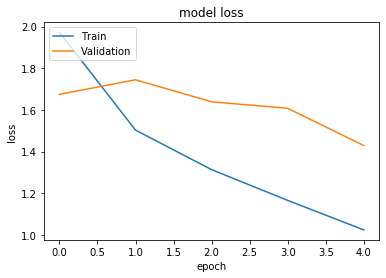

In [35]:
plt.plot(cnn_2.history['loss'])
plt.plot(cnn_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

**Plot Accuracy Vs Epochs**

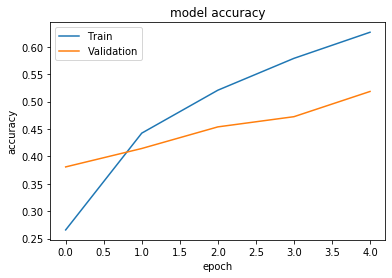

In [36]:
plt.plot(cnn_2.history['accuracy'])
plt.plot(cnn_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [37]:
score = model_2.evaluate(x_test_cnn, y_test_cnn, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.176615303325653 / Test accuracy: 0.5878000259399414
